# Model configuration

In [1]:
from typing import Tuple
import torch
from torch import nn
import torch.nn.functional as F
import time
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import random
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# -------------------------------
'''Evaluate Function'''
def NSE(obs, sim):
    obs, sim = obs.squeeze(), sim.squeeze()
    a=((obs-sim)**2).sum()
    c=obs.mean()
    b=((obs-c)**2).sum()
    return 1-a/b

def RMSE(obs, sim):
    return np.sqrt(((obs-sim)**2).mean())

def MSE(obs, sim):
    return ((obs-sim)**2).mean()

def PBIAS(obs, sim):
    a=(sim-obs).sum()
    b=obs.sum()
    return 100*a/b

def KGE(y_true, y_pred):
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.sum(y_pred) / np.sum(y_true)
    gamma = np.std(y_pred) / np.std(y_true)
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge

#---------------------------------
'''ConvLSTM Module'''

class ConvLSTMCell(nn.Module):
    """
    ConvLSTM cell.

        Parameters
        ----------
        in_channel: int
            Number of channels of input tensor.
        hidden_channel: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
    """
    def __init__(self, in_channel, hidden_channel, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        self.in_channel = in_channel
        self.hidden_channel = hidden_channel
        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.in_channel+self.hidden_channel,
                              out_channels=4*self.hidden_channel,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, inputs, states):
        h, c = states
        
        combined = torch.cat([inputs, h], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_channel, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_channel, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_channel, height, width, device=self.conv.weight.device))
    
def init_weights(m):
    if type(m) == nn.Linear:
        try:
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, val=0)
        except:
            pass

#--------------------------------
'''Spatial Attention'''
class ChannelMaxPool(nn.Module):
    def __init__(self, kernel_size, **kwargs):
        super(ChannelMaxPool, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        
    def forward(self, inputs):
        n, c, w, h = inputs.size()
        inputs = inputs.view(n, c, w * h).permute(0, 2, 1)
        pooled = F.max_pool1d(inputs, self.kernel_size)
        _, _, c = pooled.size()
        pooled = pooled.permute(0, 2, 1)
        return pooled.view(n, c, w, h)

class ChannelAvgPool(nn.Module):
    def __init__(self, kernel_size, **kwargs):
        super(ChannelAvgPool, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        
    def forward(self, inputs):
        n, c, w, h = inputs.size()
        inputs = inputs.view(n, c, w * h).permute(0, 2, 1)
        pooled = F.avg_pool1d(inputs, self.kernel_size)
        _, _, c = pooled.size()
        pooled = pooled.permute(0, 2, 1)
        return pooled.view(n, c, w, h)

class ConvAttention(nn.Module):
    """
    Convolutional Attention (Woo et al, 2018). see https://arxiv.org/pdf/1807.06521.pdf
    
    idea: 
        F' = Ms(F) * F <-- spatial attention
        
        where
        the spatial attention weight is
            Ms(F) = sigmoid(f_{7x7}([AvgPool_c(F); MaxPool_c(F)])) --> shape: (N, 1, h, w)
    
    input: 
        h_t shape: (N, C, h, w) --> ht shape: (N, C, h*w)
        x_t shape: (N, 1, h, w)
    
    after spatial attention: 
    element-wise multiplication gives new values with the shape of (N, C, h, w)
    therefore, use dot product
    
    output: the redistributed ht (N, 1, C)
    
    """
    def __init__(self, num_filter, dropout, **kwargs):
        super(ConvAttention, self).__init__(**kwargs)
        # nn.Linear Applies a linear transformation to the incoming data, xA.T+b,
        # where x has the shape of (N, in_dim), A has the shape of (out_dim, in_dim),
        # and b has the shape of (out_dim,), therefore, 
        # the output should have the shape of (N, out_dim)
        
        # nn.matmul: mat1 (N, N, M), mat2 (N, M, P) --> output (N, N, P)
        self.avg_pool = ChannelAvgPool(kernel_size=num_filter)
        self.max_pool = ChannelMaxPool(kernel_size=num_filter)
        self.conv_7x7 = nn.Conv2d(in_channels=5,
                                  out_channels=1,
                                  kernel_size=7,
                                  padding=3,
                                  bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, xt, ht, ct):
        ht_avg = self.avg_pool(ht) # (N, 1, h, w)
        ht_max = self.max_pool(ht) # (N, 1, h, w)
        
        ct_avg = self.avg_pool(ct) # (N, 1, h, w)
        ct_max = self.max_pool(ct) # (N, 1, h, w)
        
        """use xt, ct_avg, ct_max, ht_avg, ht_max."""
        ht_cat = torch.cat([xt, ct_avg, ct_max, ht_avg, ht_max], axis=1) # (N, 5, h, w)
        
        #===================================
        '''use softmax function.'''

        #-----------------------------------
        #"""this is the version for no constraint on the study area"""
        self.attention_weights = F.softmax(self.conv_7x7(ht_cat).flatten(start_dim=2), dim=-1) # (N, 1, h*w)
        values_new = ht * self.attention_weights.reshape(ht_avg.shape) # (N, C, h, w)
        values_new = values_new.sum(axis=1, keepdim=True)
        #-----------------------------------

        #===================================
        
        return values_new, self.attention_weights.reshape(ht_avg.shape), [ct_avg, ct_max, ht_avg, ht_max]

#------------------------------------------------
'''Model building'''
class ConvLSTM_attn(nn.Module):
    def __init__(self, num_filter, in_channel, dropout):
        super(ConvLSTM_attn, self).__init__()
        self.convlstm = ConvLSTMCell(in_channel=in_channel,
                                     hidden_channel=num_filter,
                                     kernel_size=(3, 3),
                                     bias=True)
        
        self.attn_space = ConvAttention(num_filter=num_filter, dropout=dropout)

    def roll(self, seq_len, x, h_t, c_t):
        hs, cs = [], []
        
        for t in range(seq_len):
            h_t, c_t = self.convlstm(inputs=x[:, :, t, :, :],
                                     states=[h_t, c_t])
            hs += [h_t]
            cs += [c_t]
        
        return hs, cs

    def forward(self, x, states=None):
        """
        Parameters
        ----------
        inputs:
            5-D Tensor of shape (b, c, t, h, w)        #   batch, channel, time, height, width
        """

        batch_size, _, seq_len, h, w = x.size()
        
        h_t, c_t = self.convlstm.init_hidden(batch_size=batch_size, image_size=(h, w)) if states == None else states
        
        hs, cs = self.roll(seq_len, x, h_t, c_t)
        # hs[t] should have the shape of (N, C, h, w)
        
        # the output of attention should be (N, 1, h, w)
        weighted_focus_saved = [(self.attn_space(x[:, :, t, :, :], hs[t], cs[t])) for t in range(len(hs))]
        gridded_runoff = [weighted_focus_saved[t][0] for t in range(len(hs))]
        attention_weights = [weighted_focus_saved[t][1] for t in range(len(hs))]
        states_stored = [weighted_focus_saved[t][2] for t in range(len(hs))]
        
        weighted_focus = [gridded_runoff[t].sum(axis=-1).sum(axis=-1) for t in range(len(hs))]
        outputs = torch.stack([weighted_focus[t] for t in range(len(hs))], axis=1)
        
        return outputs, torch.stack(gridded_runoff, axis=1), torch.stack(attention_weights, axis=1), states_stored

#------------------------------------------------
'''Model without attention'''
class ConvLSTM(nn.Module):
    def __init__(self, num_filter, in_channel, dropout):
        super(ConvLSTM, self).__init__()
        self.convlstm0 = ConvLSTMCell(in_channel=in_channel,
                                     hidden_channel=num_filter,
                                     kernel_size=(3, 3),
                                     bias=True)
        self.pool = nn.AvgPool2d((2, 2), stride=(2, 2))
        self.fc = nn.Linear(in_features=num_filter*14*9, out_features=1, bias=True)
        self.dropout = nn.Dropout(p=dropout)

    def roll(self, seq_len, x, h_t, c_t):
        hs, cs = [], []
        
        for t in range(seq_len):
            h_t, c_t = self.convlstm0(inputs=x[:, :, t, :, :],
                                        states=[h_t, c_t])
            c_t = self.dropout(c_t)
            
            hs += [self.pool(h_t)]
            cs += [self.pool(c_t)]
        
        return h_t, c_t, hs, cs

    def forward(self, x, states=None):
        """
        Parameters
        ----------
        inputs:
            5-D Tensor of shape (b, c, t, h, w)        #   batch, channel, time, height, width
        """

        batch_size, _, seq_len, h, w = x.size()
        
        h_t, c_t = self.convlstm0.init_hidden(batch_size=batch_size, image_size=(h, w)) if states == None else states
        
        h_t, c_t, hs, _ = self.roll(seq_len, x, h_t, c_t)
        outputs = torch.stack([self.dropout(self.fc(hs[i].flatten(start_dim=1))) for i in range(len(hs))], axis=1)
        outputs = F.relu(outputs)
        
        return outputs

#------------------------------------------------
def loadData(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

def wrapData(data_range, batch_size, DEVICE, is_train, dp_save):
    '''Wrap the datasest as data iter.'''
    start_pre_dataset = time.time()
    Xs, ys = [], []
    
    for k in data_range:
        file = np.load(dp_save+'LoganRiver_'+str(k)+'.npz')
        Xs.append(torch.Tensor(file['X']))
        ys.append(torch.Tensor(file['y']))

    features, labels = torch.stack(Xs, axis=0).to(DEVICE), torch.stack(ys, axis=0).to(DEVICE)
    data_iter = loadData((features, labels), batch_size, is_train=is_train)
    print('Time cost %.3fs during preparing the data iter' %(time.time()-start_pre_dataset))
    return data_iter

def validate(net, data_iter, loss):
    """Evaluate the loss for a model on a dataset during the training process."""
    net.eval()
    ls, n = .0, 0
    with torch.no_grad():
        for X, y in data_iter:
            out, _, _, _ = net(X.unsqueeze(1))
            l = loss(out, y)
            ls += l.detach().cpu().numpy()
            n += len(out.reshape(-1))
    return ls/n

def evaluate(net, data_iter):
    """Return the prediction after the training process."""
    net.eval()
    
    start = time.time()
    
    sims, obss = [], []
    with torch.no_grad():
        for X, y in data_iter:
            out, _, _, _ = net(X.unsqueeze(1))
            sims.append(out.squeeze().detach().cpu().numpy())
            obss.append(y.squeeze().detach().cpu().numpy())
    print('Time cost %.3fs in total' %(time.time() - start))
    return obss, sims

def train(net, trainer, loss, train_iter, val_iter, num_epochs): 
    '''
    train the model.
    '''
    start_all = time.time()
    net.train()
    train_ls_all_epoch, val_ls_all_epoch = [], []
    
    for epoch in range(num_epochs):
        start = time.time()
        ls = .0
        n = 0
        for X, y in train_iter:
            out, _, _, _ = net(X.unsqueeze(1))
            l = loss(out, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            ls += l.detach().cpu().numpy()
            n += len(out.reshape(-1))
        train_ls_all_epoch.append(ls/n)
        val_ls = validate(net, val_iter, loss)
        val_ls_all_epoch.append(val_ls)
        print('Epoch %d: train loss %.6e, test loss %.6e, time cost %.3fs' %(epoch+1, ls/n, val_ls, time.time()-start))
    print('Time cost %.3fs total' %(time.time()-start_all))
    return train_ls_all_epoch, val_ls_all_epoch

c:\Users\qlongyan.ASURITE\Miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


# Load data

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# data_range = [i for i in range(9)]
# train_range = random.sample(data_range, 8)
# train_rest = [i for i in data_range if i not in train_range]
# val_range = random.sample(train_rest, 1)
# test_range = [9, 10, 11, 12]

# We prepare the very long sequence for the whole train, validation and test period here, 
# to accelerate the training process, the data chuck can be divived to more pieces
train_range = [0]
val_range = [1]
test_range = [2]

train_range, val_range

([0], [1])

# Train the model

In [9]:
dp_save = '../data/data_packed/'

batch_size = 8
lr = 1e-3
num_epochs = 3

train_iter = wrapData(train_range, batch_size, DEVICE, is_train=True, dp_save=dp_save)
val_iter = wrapData(val_range, batch_size, DEVICE, is_train=True, dp_save=dp_save)
# test_iter = wrapData(test_range, batch_size, DEVICE, is_train=False, dp_save=dp_save)
#%%------------------------------------------------------------------------

'''With attention'''
net = ConvLSTM_attn(num_filter=20, in_channel=1, dropout=.2)

'''Without attention'''
# net = ConvLSTM(num_filter=20, in_channel=1, dropout=.2)

#%%------------------------------------------------------------------------
'''train from scratch'''
net.to(DEVICE)
net.apply(init_weights)

#%%------------------------------------------------------------------------
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('total number of parameters:', pytorch_total_params)

#%%------------------------------------------------------------------------
loss = nn.MSELoss()
trainer = torch.optim.Adam(net.parameters(), lr=lr)

for p in net.parameters():
    if p.requires_grad:
        print(p.shape)

Time cost 0.077s during preparing the data iter
Time cost 0.012s during preparing the data iter
total number of parameters: 15445
torch.Size([80, 21, 3, 3])
torch.Size([80])
torch.Size([1, 5, 7, 7])


In [10]:
train_ls_all_epoch, val_ls_all_epoch = train(net, trainer, loss, train_iter, val_iter, num_epochs)

Epoch 1: train loss 5.184682e-06, test loss 3.392755e-05, time cost 38.020s
Epoch 2: train loss 3.754370e-06, test loss 2.494710e-05, time cost 50.158s
Epoch 3: train loss 2.723071e-06, test loss 1.901933e-05, time cost 54.103s
Time cost 142.281s total


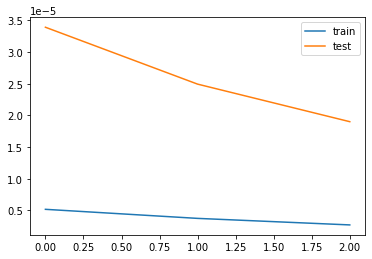

In [11]:
plt.plot(train_ls_all_epoch, label='train')
plt.plot(val_ls_all_epoch, label='test')
plt.legend()
plt.show()